# Programming Assignment: AI Powered Request Dispatcher

In the world of AI-powered chat and large language models, delivering a great response begins with understanding the user's prompt. Before any system can act, it must first know what is being asked. Is the user asking a question? Do they want to brainstorm ideas? Or are they requesting a summary?

This is the pivotal challenge you will solve in this assignment. You're going to build an **AI Powered Request Dispatcher**, the essential first step for any advanced AI system. Your model will learn to analyze and classify the intent behind any user request, ensuring it gets routed to the correct specialized tool for a perfect response. Think of it as the smart front door for a powerful AI application.

This assignment will guide you through the entire process, from handling raw data to fine-tuning a sophisticated, pre-trained model. You'll see firsthand how foundational concepts come together to create a practical, real-world tool.

Specifically, you'll do the following steps:

* **Preparing the Data**: You'll start with the **Databricks Dolly 15k dataset**, a high-quality collection of instructions, and preprocess it by consolidating categories and converting them into numerical labels ready for the model.
* **Setting Up the Foundation**: You will leverage **DistilBERT**, a fast and powerful pre-trained model, and its tokenizer to serve as the core of your dispatcher.
* **Assembling the Data Feed**: You'll construct a custom PyTorch `Dataset` for on-the-fly tokenization and build `DataLoaders` to efficiently batch and serve data to the model during training.
* **Optimizing the Fine-Tuning Process**: You'll implement advanced strategies to make your training more effective. This includes calculating **class weights** to handle imbalanced data and using partial freezing for efficient fine-tune training.
* **Training and Evaluation**: Finally, you'll bring everything together to train your dispatcher, analyze its performance with a confusion matrix, and test its real-world capabilities on new, unseen instructions.

Let's begin building the intelligent core of your next great AI application!

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

## Table of Contents
- [Imports](#0)
- [1 - The Databricks Dolly 15k Dataset](#1)
    - [1.1 - Preparing the Instruction Data](#1-1)
- [2 - Setting Up the Foundation: DistilBERT](#2)
- [3. Assembling the Data Feed for Training](#3)
    - [3.1 - Creating a Custom PyTorch Dataset](#3-1)
        - **[Exercise 1 - InstructionDataset](#ex-1)**
    - [3.2 - Splitting Data for Training and Validation](#3-2)
    - [3.3 - Defining the Data Collator](#3-2)
        - **[Exercise 2 - create_data_collator](#ex-2)**
    - [3.4 - Constructing the Data Loaders](#3-4)
        - **[Exercise 3 - create_dataloaders](#ex-3)**
- [4 - Optimizing the Fine-Tuning Process](#4)
    - [4.1 - Addressing Class Imbalance](#4-1)
        - **[Exercise 4 - calculate_class_weights](#ex-4)**
    - [4.2 Configuring the Loss Function](#4-2)
    - [4.3 - Implementing an Efficient Fine-Tuning Strategy](#4-3)
        - - **[Exercise 5 - partially_freeze_bert_layers](#ex-5)**
- [5 - Training the Dispatcher](#5)
    - **[Exercise 6 - Configuring the Training Run](#5)**
- [6 - (Optional) Evaluating the Dispatcher](#6)
    - [6.1 - Analyzing Dispatcher Performance](#6-1)
    - [6.2 - Testing the Dispatcher on Unseen Instructions](#6-2)

<a name='0'></a>
## Imports

In [1]:
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import transformers

In [2]:
import helper_utils
import unittests

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1 - The Databricks Dolly 15k Dataset

Every great AI system is built on a foundation of high-quality data. For your **AI Powered Request Dispatcher**, that foundation is the [Databricks Dolly 15k](https://www.kaggle.com/datasets/snehilsanyal/databricks-dolly-15k-dataset), an open source, instruction following dataset created by thousands of Databricks employees. It contains over 15,000 high quality prompt and response pairs designed to make language models more helpful and interactive.

For your task of building a dispatcher, you will focus on two key columns: `instruction`, which contains the user prompt, and `category`, which describes the type of task the instruction represents (e.g., `open_qa`, `summarization`, `creative_writing`).

#### How the Dataset Was Augmented

To build a truly robust dispatcher, you can't just rely on the original data. That's why this dataset has been augmented using a professional technique called **back-translation**. This process created new training examples that are grammatically different but semantically similar to the original ones.

Essentially, each instruction was translated from English into 10 different intermediate languages, such as Arabic, Urdu, and German, and then immediately translated back to English. This process created new sentences with slightly different wording but the same core meaning. These unique variations were then combined with the original data to create a larger and more diverse set of examples for your training, growing the dataset from approximately 15,000 to 26,000 instructions.

If you are interested in the specifics, you can take a look at the `augment_dataset_with_back_translation` function that was used for it, which can be found in the `helper_utils.py` file.

With this powerful, augmented dataset in hand, your first mission is to preprocess and shape it into the perfect fuel for your model.

<a name='1-1'></a>
### 1.1 - Preparing the Instruction Data

Your journey from raw data to a trained model begins with the first step of **preprocessing**. This is where you clean, refine, and structure your dataset to ensure your dispatcher learns from clear and meaningful signals.

* Load the dataset from `"./databricks-dolly-15k-dataset/databricks-dolly_augmented.csv"` as a DataFrame and remove any incomplete rows to ensure data integrity.

In [4]:
# Load the dataset and remove any rows with missing values to ensure data quality.
data_path = "./databricks-dolly-15k-dataset/databricks-dolly_augmented.csv"
df = pd.read_csv(data_path).dropna().reset_index(drop=True)

<br>

First, get a high-level view of the initial state of the dataset. By inspecting the **unique categories**, you can understand the different types of instructions that are present for your dispatcher to potentially learn from.

In [5]:
# Get a list of the unique category names from the 'category' column.
unique_categories = df['category'].unique().tolist()

In [6]:
# Print the list of unique categories to see the initial state.
print("Initial categories in the dataset:\n")
pprint(unique_categories)

Initial categories in the dataset:

['closed_qa',
 'classification',
 'open_qa',
 'information_extraction',
 'brainstorming',
 'general_qa',
 'summarization',
 'creative_writing']


<br>

A quick look at the first few rows should confirm that your data has loaded correctly and gives you a feel for the structure you'll be working with.

In [7]:
# EDITABLE CELL

df.head(10)

,instruction,category
0,When did Virgin Australia start operating?,closed_qa
1,Which is a species of fish? Tope or Rope,classification
2,Why can camels survive for long without water?,open_qa
3,"Alice's parents have three daughters: Amy, Jes...",open_qa
4,When was Tomoaki Komorida born?,closed_qa
5,If I have more pieces at the time of stalemate...,information_extraction
6,"Given a reference text about Lollapalooza, whe...",closed_qa
7,Who gave the UN the land in NY to build their HQ,open_qa
8,Why mobile is bad for human,brainstorming
9,Who was John Moses Browning?,information_extraction


<br>

In a real-world project, you often need to make strategic decisions about your target classes. The raw dataset has several granular categories. To create a more focused and effective dispatcher for this assignment, you'll consolidate similar categories. This common practice simplifies the classification task and can lead to a more robust model.

* You'll merge all question answering types into a single `q_and_a` target and combine `information_extraction` with `summarization` to create a new `information_distillation` category. This simplifies the set of routing targets your dispatcher needs to learn.

In [8]:
# Create a mapping dictionary to define how categories should be merged.
# Keys are the old category names, and values are the new, consolidated names.
category_map = {
    "general_qa": "q_and_a",
    "open_qa": "q_and_a",
    "closed_qa": "q_and_a",
    "information_extraction": "information_distillation",
    "summarization": "information_distillation"
}

# Use the replace() method on the 'category' column to apply the mapping.
df['category'] = df['category'].replace(category_map)

<br>

With your final categories defined, it's time to translate them into a format the model can understand. You'll convert your text categories into numerical **labels**. You'll also create a reverse mapping dictionary, a tool that will allow you to convert the model's numerical output back into human-readable predictions later on.

In [9]:
# Get an array of the unique, consolidated category names.
unique_categories = df['category'].unique()

# Create a dictionary to map each category name to a unique integer ID.
cat2id = {category: i for i, category in enumerate(unique_categories)}

# Create the new 'label' column in the DataFrame by applying the mapping.
# The .map() function efficiently converts each category name to its corresponding integer ID.
df['label'] = df['category'].map(cat2id)

# Create the reverse mapping from integer ID back to the category name.
id2cat = {id: category for category, id in cat2id.items()}

<br>

To finalize this stage of your data pipeline, you'll extract the core components, the `instruction` texts and their corresponding numerical `labels`, into dedicated lists, ready for the next phase.

In [10]:
# Extract the 'instruction' and 'label' columns into lists
texts = df['instruction'].tolist()
labels = df['label'].tolist()

<br>

Perform a final check. A quick look at the class distribution should confirm you that the preprocessing steps were successful and show you the final number of samples for each category.

In [11]:
print(f"Total samples for classification: {len(texts)}\n")
print("Class distribution:")

# Iterate through the category-to-ID mapping to report on each class.
for category, label_id in cat2id.items():
    count = labels.count(label_id)
    print(f"  - label {label_id}: {category:<25} {count} samples")

Total samples for classification: 26238

Class distribution:
  - label 0: q_and_a                   13243 samples
  - label 1: classification            3918 samples
  - label 2: information_distillation  4681 samples
  - label 3: brainstorming             3113 samples
  - label 4: creative_writing          1283 samples


<br>

Take a sneak peek at the final product of your preprocessing pipeline: clean, labeled data. This is exactly the format your `Dataset` and `DataLoaders` will use to feed the dispatcher during training.

* Feel free to change the values of `num_samples` and `random_state`.

In [12]:
# EDITABLE CELL

# Set the number of random samples to display, and random_state.
num_samples = 10
random_state = 25

# Display a sample of instruction and label pairs.
display(df[['instruction', 'label']].sample(num_samples, random_state=random_state).style.hide(axis="index"))

instruction,label
Who is the best NBA player of all time?,0
Where is Seinäjoki City Hall?,2
How difficult is it to learn how to juggling?,0
"Identify the bird from the list: Queensbury, Kingfisher, Bishopsgate",1
Give me some strategies to prevent procrastination,3
Who won the 149 boat race?,0
Plan a weekend vacation to Madrid and mention several specific places that you would visit and how you would travel in the city,4
"Classify each of the following as characters from books J.K. Rowling has written or books that Suzanne Collins has written: Peeta Mellark, Katness Everdeen, Effie Trinket, Seneca Crane, Lucy Gray, Cinna, Harry Potter, Severus Snape, Hermione Granger, Albus Dumbledore",1
"How did Andy Warhol create the ""piss paintings""?",0
How far is the town of Warsaw?,2


<a name='2'></a>
## 2 - Setting Up the Foundation: DistilBERT

With your data perfectly prepped, it's time to select the engine for your dispatcher. In modern NLP, you rarely build from scratch. Instead, you'll leverage a powerful, pre-trained foundation to give your project a massive head start.

Your choice is [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert): a lean, efficient, and powerful version of the original BERT. For a dispatcher that needs to be fast and responsive, DistilBERT is the perfect starting point.

Of course, a model is only as good as its understanding of language. Alongside the model, you'll load its corresponding **tokenizer**. This integral component is responsible for translating your raw text instructions into the numerical format that DistilBERT understands, acting as the bridge between human language and the model's brain.

* Download the pre-trained model and its tokenizer.

In [13]:
model_name="distilbert-base-uncased"
model_path="./distilbert-local-base"

# Ensure the model is downloaded
helper_utils.download_bert(model_name, model_path)

Base model 'distilbert-base-uncased' already available at ./distilbert-local-base


<br>

* Load the DistilBERT model and its tokenizer into memory, officially setting up the core of your AI dispatcher.

**Note**: You will see a warning that some weights were "newly initialized." This is expected. It confirms that you have successfully loaded the pre-trained DistilBERT base and attached a new, untrained classification head. 

In [14]:
# Get the number of unique classes from the 'category' column.
num_classes = df['category'].nunique()

# Load the pre-trained DistilBERT model and its tokenizer from the local path.
bert_model, bert_tokenizer = helper_utils.load_bert(model_path, 
                                                    num_classes=num_classes
                                                   )

Loading base model from ./distilbert-local-base and adding a new head with 5 classes.



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ./distilbert-local-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model and tokenizer loaded successfully.


<a name='3'></a>
## 3. Assembling the Data Feed for Training
Your model's engine (DistilBERT) is ready, and your fuel (the preprocessed data) is refined. Now, you need to build the pipeline that connects them.

This section is all about creating an efficient, automated data feed for your dispatcher. You'll construct the essential PyTorch components, a custom `Dataset` and powerful `DataLoaders`, that will handle tokenization, batching, and shuffling, ensuring a smooth and efficient training process.

<a name='3-1'></a>
### 3.1 - Creating a Custom PyTorch Dataset

The heart of your data pipeline will be a custom `InstructionDataset`. This is not going to be just a simple data container, but an intelligent component that will perform on-the-fly tokenization.

Every time the training loop will request a sample, your `Dataset` will grab the raw text, instantly tokenize it with your DistilBERT tokenizer, and pair it with its correct label. This "just-in-time" processing is an efficient and standard practice in modern NLP pipelines.

<a name='ex-1'></a>
### Exercise 1 - InstructionDataset

Now it's your turn to build this core component. Implement the `InstructionDataset` class, which will serve as the blueprint for preparing each individual sample for your model.

**Your Task**:

* **Inside the `__init__` method:**
    * This method sets up the dataset. You need to store the lists of `texts` and `labels`, along with the `tokenizer`, so they can be used later.
    * Assign them as they are passed in to their corresponding instance attributes.
* **Inside the `__getitem__` method**:
    * **Fetch the data**: Get the specific `text` and `label` for the given index (`idx`).
    * **Tokenize the text**: Use the `self.tokenizer` to convert the raw `text` string into a processed `encoding`. You must set `truncation` to `True` and `max_length` to `512`.
        * This encoding will be a dictionary containing `input_ids` and `attention_mask`.
    * **Add the label**: Add the integer `label` to the encoding dictionary with the key `'labels'`. It's important to convert this label into a `torch.tensor` of type `torch.long`.
 
<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

If you're stuck, here is a more detailed breakdown.

**For the __init__ method:**
* This is a standard Python constructor. You're just saving the arguments for later use.
* For example, the first line will be `self.texts = texts`. Follow this pattern for `labels` and `tokenizer`.

**For the __getitem__ method**:
* Fetching the data: Use standard list indexing to get an item from your stored lists (e.g., `text = self.texts[idx]`).

* **Tokenizing**: The tokenizer is callable. You pass the `text` string, and `truncation` and `max_length` parameters. The call will look like this:
    * > `encoding = call the tokenizer on (the text, with the truncation option set to True, and the max_length option set to 512)`

* **Adding the label**: This is a two-part step. First, access the dictionary key: `encoding['labels'] = ....` The value you assign should be the label converted to the correct tensor type. This will look like this:
    > `encoding['labels'] = create a new torch.tensor(from the label, and set the dtype to torch's long integer type)`

</details>

In [15]:
# GRADED CLASS: InstructionDataset

class InstructionDataset(Dataset):
    """
    Custom PyTorch Dataset for text classification.

    This Dataset class stores raw texts and their corresponding labels. It is
    designed to work efficiently with a Hugging Face tokenizer, performing
    tokenization on the fly for each sample when it is requested.

    Args:
        texts (list[str]): A list of raw text strings.
        labels (list[int]): A list of integer labels corresponding to the texts.
        tokenizer: A Hugging Face tokenizer instance used for processing text.
    """
    def __init__(self, texts, labels, tokenizer):
        
        ### START CODE HERE ###
        
        # Store the list of raw text strings
        self.texts = texts
        # Store the list of integer labels
        self.labels = labels
        # Store the tokenizer instance that will process the text
        self.tokenizer = tokenizer

        ### END CODE HERE ###

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves and processes one sample from the dataset.

        For a given index, this method fetches the corresponding text and label,
        tokenizes the text, and returns a dictionary of tensors.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the tokenized inputs ('input_ids',
                  'attention_mask') and the 'labels' as tensors.
        """

        ### START CODE HERE ###
        
        # Get the raw text and label for the specified index
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text. This single call handles cleaning, tokenization,
        # conversion to numerical IDs, and truncation.
        # Set `truncation` to `True` and `max_length` as 512
        encoding = self.tokenizer(text,truncation=True,max_length=512)

        # Add the label to the encoding dictionary and convert it to a tensor
        # Set `dtype` as `torch.long`
        encoding['labels'] = torch.tensor(label,dtype=torch.long)

        ### END CODE HERE ###

        return encoding

In [16]:
# Initialize the dataset to verify
verify_class = InstructionDataset(texts, labels, bert_tokenizer)

print(f"Dataset initialized with {len(verify_class)} total samples.")
print("-" * 50)


# Display the first 3 instructions and their corresponding labels
print("Displaying the first 3 instructions and labels from your data:\n")
for i in range(3):
    print(f"Instruction: {verify_class.texts[i]}")
    print(f"Label:       {verify_class.labels[i]}\n")
print("-" * 50)

Dataset initialized with 26238 total samples.
--------------------------------------------------
Displaying the first 3 instructions and labels from your data:

Instruction: When did Virgin Australia start operating?
Label:       0

Instruction: Which is a species of fish? Tope or Rope
Label:       1

Instruction: Why can camels survive for long without water?
Label:       0

--------------------------------------------------


#### Expected Output:

```
Dataset initialized with 26238 total samples.
--------------------------------------------------
Displaying the first 3 instructions and labels from your data:

Instruction: When did Virgin Australia start operating?
Label:       0

Instruction: Which is a species of fish? Tope or Rope
Label:       1

Instruction: Why can camels survive for long without water?
Label:       0

--------------------------------------------------
```

In [17]:
# Test your code!
unittests.exercise_1(InstructionDataset)

 All tests passed!


<a name='3-2'></a>
### 3.2 - Splitting Data for Training and Validation

With your `InstructionDataset` class defined, create an instance containing your entire preprocessed dataset.

However, to build a reliable model, you must evaluate its performance honestly. This means testing it on data it has never seen during training. A model that performs well on training data but fails on new data isn't truly intelligent, it has simply memorized the answers.

Therefore, an important step in any machine learning pipeline is to partition the data. You will split your full dataset into a large **training set** to teach the model, and a smaller **validation set** to rigorously and impartially test its ability to generalize.

* Create the `full_dataset` object by passing your prepared `texts`, `labels`, and `bert_tokenizer` to the `InstructionDataset` class.

In [18]:
# Create the full dataset
full_dataset = InstructionDataset(texts, labels, bert_tokenizer)

* Split the `full_dataset` into an 80% training set and a 20% validation set.

In [19]:
# Split the full dataset into an 80% training set and a 20% validation set.
train_dataset, val_dataset = helper_utils.create_dataset_splits(
    full_dataset, 
    train_split_percentage=0.8
)

# Print the number of samples in each set to verify the split.
print(f"Training samples:    {len(train_dataset)}")
print(f"Validation samples:  {len(val_dataset)}")

Training samples:    20990
Validation samples:  5248


<a name='3-3'></a>
### 3.3 - Defining the Data Collator

Your data pipeline is taking shape. You have your datasets, but there's a practical challenge to solve before you can create batches: your tokenized instructions are all different lengths, in other words each sentence has different number of words. To train your model efficiently, each batch of data must be a uniform tensor. To handle this, you need a component that can dynamically pad the shorter sequences so that every instruction in the batch matches the length of the longest one. This will ensure perfectly shaped, rectangular tensors are always fed to your dispatcher. You need a **data collator**.

<a name='ex-2'></a>
### Exercise 2 - create_data_collator

Your next task is to implement the function, `create_data_collator`, that creates this essential padding component for your data pipeline.

**Your Task**:

* Inside the function, you need to create an instance of the `transformers.DataCollatorWithPadding` class.
* During initialization, you must pass the `tokenizer` to the `tokenizer` parameter of the class.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

This exercise involves initializing a class from the `transformers` library and assigning it to the `collator` variable.

The call will look like this:

> `collator = create an instance of the DataCollatorWithPadding class, and pass the tokenizer to its 'tokenizer' parameter`

</details>

In [20]:
# GRADED FUNCTION: create_data_collator

def create_data_collator(tokenizer):
    """
    Initializes and returns a data collator for dynamic padding.
    
    Args:
        tokenizer: A Hugging Face tokenizer instance.
    
    Returns:
        collator: A transformers.DataCollatorWithPadding instance.
    """

    ### START CODE HERE ###
    
    # Initialize the data collator
    collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)

    ### END CODE HERE ###
    
    return collator

In [21]:
# Create a few tokenized samples with different lengths to simulate a batch
sample_1 = bert_tokenizer("This is a short sentence.")
sample_1['labels'] = torch.tensor(0)
sample_2 = bert_tokenizer("This particular sentence is quite a bit longer.")
sample_2['labels'] = torch.tensor(1)
manual_batch = [sample_1, sample_2]

# Initialize the data collator
verify_function = create_data_collator(bert_tokenizer)

# Print the original, un-padded 'input_ids' for each sample
print("--- Before Collation (Original input_ids) ---")
for i, sample in enumerate(manual_batch):
    print(f"Sample {i+1} 'input_ids': {sample['input_ids']}")

print("\n--- After Collation (Padded and batched) ---")
# Pass the list of samples to the collator and inspect the result
collated_batch = verify_function(manual_batch)

# Directly print the final tensor
print(collated_batch['input_ids'])

--- Before Collation (Original input_ids) ---
Sample 1 'input_ids': [101, 2023, 2003, 1037, 2460, 6251, 1012, 102]
Sample 2 'input_ids': [101, 2023, 3327, 6251, 2003, 3243, 1037, 2978, 2936, 1012, 102]

--- After Collation (Padded and batched) ---
tensor([[ 101, 2023, 2003, 1037, 2460, 6251, 1012,  102,    0,    0,    0],
        [ 101, 2023, 3327, 6251, 2003, 3243, 1037, 2978, 2936, 1012,  102]])


#### Expected Output:

```
--- Before Collation (Original input_ids) ---
Sample 1 'input_ids': [101, 2023, 2003, 1037, 2460, 6251, 1012, 102]
Sample 2 'input_ids': [101, 2023, 3327, 6251, 2003, 3243, 1037, 2978, 2936, 1012, 102]

--- After Collation (Padded and batched) ---
tensor([[ 101, 2023, 2003, 1037, 2460, 6251, 1012,  102,    0,    0,    0],
        [ 101, 2023, 3327, 6251, 2003, 3243, 1037, 2978, 2936, 1012,  102]])
```

In [22]:
# Test your code!
unittests.exercise_2(create_data_collator)

 All tests passed!


<br>

Great work! With your function correctly defined, create the official `data_collator` instance. This component is now ready to be plugged into the final stage of your data pipeline.

In [23]:
data_collator = create_data_collator(bert_tokenizer)

<a name='3-4'></a>
### 3.4 - Constructing the Data Loaders

You've reached the final assembly stage of your data pipeline. You have the refined data (`Dataset`) and the padding mechanism (`DataCollator`). Now you need to bring them together with `DataLoaders`.

These powerful iterators are the workhorses that will serve up perfectly collated and shuffled batches to your model, completing the automated bridge between your raw data and your dispatcher's training loop.

<a name='ex-3'></a>
### Exercise 3 - create_dataloaders

Implement the `create_dataloaders` function to produce two `DataLoader` instances.

Your final task for the data pipeline section is to implement the function, `create_dataloaders`, that constructs these `DataLoader` workhorses for both, your training and validation, sets.

**Your Task**:

* **Create the `train_loader`**:
    * Instantiate a `DataLoader` for the `train_dataset`.
    * You must pass the `train_dataset`, `batch_size`, and `collate_fn` to the correct parameters.
    * Set `shuffle` to `True`.
* **Create the `val_loader`**:
    * Instantiate a `DataLoader` for the `val_dataset`.
    * You must pass the `val_dataset`, `batch_size`, and `collate_fn` to the correct parameters.
    * Set `shuffle` to `False`.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

You will be creating two instances of the `DataLoader` class, one for training and one for validation.

**For the `train_loader`**:
* You need to call the `DataLoader` class and provide the correct arguments.
* The first argument is the dataset itself (`train_dataset`).
* The other arguments are passed by name: `batch_size=...`, `shuffle=...`, and `collate_fn=....` Remember to set `shuffle` to `True`.

**For the `val_loader`**:
* This is almost identical to creating the `train_loader`.
* The key difference is that you will use the `val_dataset` and, most importantly, you must set `shuffle` to `False`.

</details>

In [24]:
# GRADED FUNCTION: create_dataloaders

def create_dataloaders(train_dataset, val_dataset, batch_size, collate_fn):
    """
    Creates and returns DataLoader instances for training and validation sets.
    
    Args:
        train_dataset (Dataset): The training dataset.
        val_dataset (Dataset): The validation dataset.
        batch_size (int): The number of samples per batch.
        collate_fn (callable): The function to merge a list of samples to form a mini-batch.
    
    Returns:
        tuple: A tuple containing the training DataLoader and validation DataLoader.
    """

    ### START CODE HERE ###
    
    # Create the DataLoader for the training set
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=True
    ) 
    
    # Create the DataLoader for the validation set
    val_loader = DataLoader(
      dataset=val_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=False
    ) 

    ### END CODE HERE ###

    return train_loader, val_loader

In [25]:
# Create the DataLoaders
batch_size = 16
verify_function = create_dataloaders(train_dataset, val_dataset, batch_size, data_collator)

# Inspecting the Train Loader
first_train_batch = next(iter(verify_function[0]))
print("Shape of each tensor in the train batch:")
for key, value in first_train_batch.items():
    print(f"  - {key}: {value.shape}")

print()

# Inspecting the Validation Loader 
first_val_batch = next(iter(verify_function[1]))
print("Shape of each tensor in the validation batch:")
for key, value in first_val_batch.items():
    print(f"  - {key}: {value.shape}")

Shape of each tensor in the train batch:
  - input_ids: torch.Size([16, 65])
  - attention_mask: torch.Size([16, 65])
  - labels: torch.Size([16])

Shape of each tensor in the validation batch:
  - input_ids: torch.Size([16, 46])
  - attention_mask: torch.Size([16, 46])
  - labels: torch.Size([16])


#### Expected Output: 
##### (value of "x" below will vary for each execution):

```
Shape of each tensor in the train batch:
  - input_ids: torch.Size([16, x])
  - attention_mask: torch.Size([16, x])
  - labels: torch.Size([16])

Shape of each tensor in the validation batch:
  - input_ids: torch.Size([16, x])
  - attention_mask: torch.Size([16, x])
  - labels: torch.Size([16])
```

In [26]:
# Test your code!
unittests.exercise_3(create_dataloaders)

 All tests passed!


<br>

Fantastic! Your `create_dataloaders` function is working perfectly, producing properly shaped batches. With this, your data pipeline is officially complete. Create the final `train_loader` and `val_loader` that will fuel your model during its training.

In [27]:
batch_size = 32
train_loader, val_loader = create_dataloaders(train_dataset, val_dataset, batch_size, data_collator)

<a name='4'></a>
## 4 - Optimizing the Fine-Tuning Process

With a robust data pipeline in place, you can now turn your attention to the training process itself. Simply feeding data to a model isn't enough. Professional-grade models are trained with smart, efficient strategies.

In this section, you'll implement two powerful techniques to elevate our fine-tuning process: **weighted loss** to handle class imbalance and **partial freezing** for faster, more efficient training.

<a name='4-1'></a>
### 4.1 - Addressing Class Imbalance

A common challenge in real-world datasets is **class imbalance**. Some categories naturally have more data than others. If ignored, your model could become biased, favoring the most common instruction types and performing poorly on rarer ones.

To build a fair and reliable dispatcher, you must address this head-on. You'll calculate **class weights**, which will strategically adjust your loss function. This tells the model to pay extra attention to the under-represented categories, ensuring it learns to classify all instruction types with equal skill.

<a name='ex-4'></a>
### Exercise 4 - calculate_class_weights

Your task is to implement the function, `calculate_class_weights` that calculates these class weights.

**Your Task**:

* **Calculate Weights**:
    * Use the `compute_class_weight` function from `sklearn.utils.class_weight`.
    * You must set `class_weight` to `'balanced'` to have the function automatically calculate the weights.
    * Pass the unique class labels to the `classes` parameter. For this, you will use <code>[np.unique()](https://numpy.org/doc/2.1/reference/generated/numpy.unique.html)</code>.
    *  Pass the full list of training labels to the `y` parameter.
* **Convert to Tensor:**
    * The `compute_class_weight` function returns a NumPy array. You need to convert this array into a PyTorch tensor.
    * Ensure the tensor's data type is set to `torch.float`.
 
<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

This function involves one main function call and then a type conversion.

**For calculating the weights:**
* You will call `compute_class_weight` and assign the result to the `class_weights` variable.
* The function call will look like this:
    > `class_weights = call compute_class_weight with (class_weight set to 'balanced', classes set by calling np.unique() on the labels list, and y set to the full list of labels)`

**For converting to a tensor**:
* You will use `torch.tensor()` to convert the `class_weights` NumPy array.
* The call will follow this structure:
    > `class_weights_tensor = create a new torch.tensor(from the class_weights, and set the dtype to torch's float type)`

</details>

In [28]:
# GRADED FUNCTION: calculate_class_weights

def calculate_class_weights(train_dataset, device):
    """
    Calculates class weights for handling imbalanced datasets.
    
    Args:
        train_dataset (torch.utils.data.Subset): 
            The training dataset, expected to be a subset object containing 
            indices to the original dataset.
        device (torch.device): 
            The device (e.g., 'cuda' or 'cpu') to place the final tensor on.
    
    Returns:
        torch.Tensor: A 1D tensor of class weights.
    """
    # Extract all labels from the training set to calculate class weights
    train_labels_list = [train_dataset.dataset.labels[i] for i in train_dataset.indices]

    ### START CODE HERE ###

    # Use scikit-learn's utility to automatically calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels_list),
        y=train_labels_list
    ) 
    
    # Convert the NumPy array of weights into a PyTorch tensor of type float
    class_weights_tensor = torch.tensor(class_weights ,dtype=torch.float).to(device)

    ### END CODE HERE ###
    
    return class_weights_tensor.to(device)

In [29]:
# Calculate the class weights for the training set
verify_function = calculate_class_weights(train_dataset, device)

# Display the weights alongside their corresponding category
print("Breakdown of weights per category:")

# Sort the categories by their ID to ensure the order matches the weights tensor
sorted_categories = sorted(cat2id.items(), key=lambda item: item[1])

for category, label_id in sorted_categories:
    # .item() extracts the scalar value from the tensor
    weight = verify_function[label_id].item()
    print(f"  - {category:<25}: {weight:.4f}")

Breakdown of weights per category:
  - q_and_a                  : 0.3978
  - classification           : 1.3412
  - information_distillation : 1.1103
  - brainstorming            : 1.6955
  - creative_writing         : 4.0019


#### Expected Output (Approximately):

```
Breakdown of weights per category:
  - q_and_a                  : 0.3983
  - classification           : 1.3181
  - information_distillation : 1.1231
  - brainstorming            : 1.6698
  - creative_writing         : 4.1400
```

In [30]:
# Test your code!
unittests.exercise_4(calculate_class_weights)

 All tests passed!


<a name='4-2'></a>
### 4.2 Configuring the Loss Function

With your `calculate_class_weights` function ready, it is time to put it to use.

You'll now configure your loss function. By passing these weights directly to `nn.CrossEntropyLoss`, you ensure that every time the model makes a mistake on a rare category, the penalty is higher. This is the mechanism that forces your dispatcher to become a more balanced and equitable classifier.

* Calculate `class_weights` using `train_dataset`.
* Define `nn.CrossEntropyLoss` as your loss function, and pass your calculated `class_weights` tensor to the weight parameter.

In [31]:
# Calculate the class weights for the training set
class_weights = calculate_class_weights(train_dataset, device)

# Initialize the CrossEntropyLoss function with the calculated `class_weights`.
loss_function = nn.CrossEntropyLoss(weight=class_weights)

<a name='4-3'></a>
### 4.3 - Implementing an Efficient Fine-Tuning Strategy

Now onto your second optimization strategy. Fine-tuning a language model with millions of parameters is computationally expensive and time-consuming. A more pragmatic and often equally effective approach is partial fine-tuning (also known as **parameter-efficient fine-tuning (PEFT)**).

The core idea is simple but powerful: you'll **freeze** the vast majority of the model's pre-trained layers, which already have a strong understanding of language, and only train the last few layers and the final classification head. This dramatically reduces the number of trainable parameters, leading to significantly faster training cycles without a major sacrifice in performance. It's a key strategy for developing models quickly and cost-effectively.

<a name='ex-5'></a>
### Exercise 5 - partially_freeze_bert_layers

Now, you will implement the function, `partially_freeze_bert_layers`, that will apply the logic for this efficient fine-tuning strategy.

**Your Task**:

* **Freeze All Parameters**:
    * First, you must loop through all the parameters in the `model`.
    * Inside the loop, "freeze" `requires_grad` attribute of each parameter.
* **Unfreeze the Last N Transformer Layers**:
    * The code to unfreeze the final classification head is already provided for you. Your task is to unfreeze the transformer layers just before it.
    * Loop from `i` in the range of `layers_to_train`.
    * Inside the loop, select the correct layer from `transformer_layers` using **negative indexing**. Since you want the *last* N layers, an index like `[-(i + 1)]` will work (e.g., for `i=0`, it gets the last layer; for `i=1`, the second to last, and so on).
    * Once you have the `layer_to_unfreeze`, create another loop to iterate through its specific parameters and "unfreeze" their `requires_grad` attribute.
 
<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

This function requires you to implement two separate loops.

**For freezing all parameters**:
* This is a simple loop. The first line is:
    > `for param in model.parameters():`
* Inside this loop, you just need to set the `requires_grad` attribute of the `param` to `False`.

**For unfreezing the last N layers**:
* This involves a nested loop structure.
* **Outer loop**: This should iterate up to the number of layers you want to train: `for i in range(layers_to_train):`
* **Layer Selection**: You need to select a layer from the `transformer_layers` list using a negative index to count from the end. The line will look like this:
    > `layer_to_unfreeze = select from transformer_layers using the index -(i + 1)`
* **Inner loop**: Once you have the layer, loop through its parameters just like you did when freezing them:
    > `for param in layer_to_unfreeze.parameters():`
* Inside the inner loop, set the `requires_grad` attribute of the param to `True`.

</details>

In [32]:
# GRADED FUNCTION: partially_freeze_bert_layers

def partially_freeze_bert_layers(model, layers_to_train=3):
    """
    Freezes all but the last N transformer layers and the classification head
    of a DistilBERT model. The model is modified in-place.

    Args:
        model (transformers.DistilBertForSequenceClassification):
            The DistilBERT model to modify.
        
        layers_to_train (int):
            The number of final transformer layers to unfreeze for training.
    
    Returns:
        transformers.DistilBertForSequenceClassification:
            The same model instance, now modified with the specified layers
            unfrozen.
    """
    
    ### START CODE HERE ###
    
    # First, freeze ALL model parameters
    for param in model.parameters():
        # Freeze the parameter.
        param.requires_grad = False

    ### END CODE HERE ###
    
    # Get reference to the list of transformer layers in the model.
    transformer_layers = model.distilbert.transformer.layer

    ### START CODE HERE ###

    # Loop `layers_to_train` times to unfreeze the specified number of final layers.
    for i in range(layers_to_train):
        # Use negative indexing to select layers from the end of the list.
        layer_to_unfreeze = transformer_layers[-(i+1)]

        # Iterate through all parameters *within the selected layer*.
        for param in layer_to_unfreeze.parameters():
            # Unfreeze the parameter.
            param.requires_grad = True

    ### END CODE HERE ###
    
    # Unfreeze the final classification head
    for param in model.pre_classifier.parameters():
        param.requires_grad = True
    
    for param in model.classifier.parameters():
        param.requires_grad = True
      
    return model

In [33]:
# Create a partially frozen model instance
verify_function = partially_freeze_bert_layers(bert_model)

# Iterate through the model's parameters to check their status
for name, param in verify_function.named_parameters():
    # Check a parameter from an early, frozen layer
    if 'layer.0.attention.q_lin.weight' in name:
        print(f"Parameter from an EARLY layer: '{name}'")
        print(f"  - Trainable (requires_grad): {param.requires_grad}")

    # Check a parameter from a later, unfrozen layer
    if 'layer.4.attention.q_lin.weight' in name:
        print(f"\nParameter from a LATE layer: '{name}'")
        print(f"  - Trainable (requires_grad): {param.requires_grad}")

    # Check a parameter from the final classification head
    if 'classifier.weight' in name:
        print(f"\nParameter from the CLASSIFIER head: '{name}'")
        print(f"  - Trainable (requires_grad): {param.requires_grad}")

Parameter from an EARLY layer: 'distilbert.transformer.layer.0.attention.q_lin.weight'
  - Trainable (requires_grad): False

Parameter from a LATE layer: 'distilbert.transformer.layer.4.attention.q_lin.weight'
  - Trainable (requires_grad): True

Parameter from the CLASSIFIER head: 'pre_classifier.weight'
  - Trainable (requires_grad): True

Parameter from the CLASSIFIER head: 'classifier.weight'
  - Trainable (requires_grad): True


#### Expected Output:

```
Parameter from an EARLY layer: 'distilbert.transformer.layer.0.attention.q_lin.weight'
  - Trainable (requires_grad): False

Parameter from a LATE layer: 'distilbert.transformer.layer.4.attention.q_lin.weight'
  - Trainable (requires_grad): True

Parameter from the CLASSIFIER head: 'pre_classifier.weight'
  - Trainable (requires_grad): True

Parameter from the CLASSIFIER head: 'classifier.weight'
  - Trainable (requires_grad): True
```

In [34]:
# Test your code!
unittests.exercise_5(partially_freeze_bert_layers)

 All tests passed!


<a name='5'></a>
## 5 - Training the Dispatcher

Welcome to the training stage! This is where all your hard work comes together. You've built a robust data pipeline and prepared the model by implementing various optimizations. Now, you'll orchestrate the training process, taking all the components you've meticulously built and using them to teach your AI Powered Request Dispatcher how to classify user intent.

<a name='ex-6'></a>
### Exercise 6 - Configuring the Training Run

Before starting the training loop, you'll set key hyperparameters that guide the process, specifically the number of layers to train (`layers_to_train`), the optimizer's learning rate (`learning_rate`), and the total number of training epochs (`num_epochs`). The choices you make here will directly impact the model's performance, training time, and computational cost. **Since the dataset is imbalanced, your target is to reach a validation loss below 0.7 and a validation F1 score of 0.8 or more.**

**Your Task**:

You need to set the following hyperparameters to meet your target training metrics.

* `layers_to_train`: This controls how many of the model's final transformer layers are unfrozen, balancing deeper adaptation against longer training times.
    * *DistilBERT has a total of **6 transformer layers***.
* `learning_rate`: This sets the optimizer's step size, trading off faster training speed against the risk of overshooting the best solution.
* `num_epochs`: This determines the number of full passes over the training data, balancing more thorough learning against the risk of overfitting.

As a reminder, the target is to achieve a **validation loss below 0.7** and a **validation F1 score of 0.8 or more**.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

Finding the right combination of hyperparameters is a key skill that involves experimentation. We strongly encourage you to try different values on your own first to see how they affect the outcome.

If you are stuck or would like to see a combination that is known to work well, you can **scroll to the very bottom of this notebook**. There you will find a code cell that reveals a suggested set of values.

</details>

In [35]:
# GRADED CELL: Configuring the Training Run

### START CODE HERE ###

# Set the number of final transformer layers to unfreeze for training. 
layers_to_train = 3

# Set the learning rate for the optimizer
learning_rate = 5e-5

# Set the total number of training epochs
num_epochs = 3

### END CODE HERE ###

* The `if/elif` block below acts as a safety check on the `layers_to_train` variable. It ensures the value is always valid (between 0 and 6) by automatically correcting any negative numbers to 0 and any numbers greater than 6 down to the maximum of 6 (the total number of DistilBERT's transformer layers). This makes the training setup more robust and prevents errors.

In [36]:
# Check if the value is negative
if layers_to_train < 0:
    print(f"'layers_to_train' was set to {layers_to_train}, which is not valid.\n")
    print("The number of transformer layers to train cannot be negative. Setting layers_to_train=0")
    layers_to_train = 0

# Check if the value exceeds the total number of layers in the model
elif layers_to_train > 6:
    print(f"'layers_to_train' was set to {layers_to_train}, but DistilBERT only has 6 transformer layers.\n")
    print(f"Capping at the maximum value. Setting layers_to_train = 6")
    layers_to_train = 6

* With the configuration validated, call your `partially_freeze_bert_layers` function. It creates the `partial_finetune_model`, a model instance with the specific layers unfrozen, which is now fully prepared for the training loop.

In [37]:
partial_finetune_model = partially_freeze_bert_layers(bert_model, layers_to_train)

* Execute the `training_loop` to fine-tune the dispatcher.

**Note**: Remember, your goal is to achieve a **validation loss below 0.7** and a **validation F1 score of 0.8 or more**.

In [38]:
# Call the training loop to start the partial fine-tuning process.
trained_finetuned_bert, partial_results = helper_utils.training_loop(
    model=partial_finetune_model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    loss_function=loss_function, 
    learning_rate=learning_rate, 
    num_epochs=num_epochs,
    device=device
)

# Display the results 
print("Final Validation Metrics")
print(f"\nLoss:       {partial_results['val_loss']:.4f}")
print(f"Accuracy:   {partial_results['val_accuracy']:.4f}")
print(f"F1:         {partial_results['val_f1']:.4f}\n")

Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 Training:   0%|          | 0/656 [00:00<?, ?it/s]

Epoch 1/3 Validation:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 1 Metrics -> Val Loss: 0.4733, Val Acc: 0.8197, Val F1: 0.7913


Epoch 2/3 Training:   0%|          | 0/656 [00:00<?, ?it/s]

Epoch 2/3 Validation:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 2 Metrics -> Val Loss: 0.4172, Val Acc: 0.8443, Val F1: 0.8245


Epoch 3/3 Training:   0%|          | 0/656 [00:00<?, ?it/s]

Epoch 3/3 Validation:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 3 Metrics -> Val Loss: 0.4352, Val Acc: 0.8422, Val F1: 0.8197

--- Training complete ---
Final Validation Metrics

Loss:       0.4352
Accuracy:   0.8422
F1:         0.8197



#### Expected Output:

```
--- Training complete ---
Final Validation Metrics

Loss:       < 0.7
Accuracy:   x
F1:         > 0.8
```

In [39]:
# Test your code!
unittests.exercise_6(partial_results)

 All tests passed!


#### Save your Training Logs

<p style="background-color:#ffe6f0; color:#282828; padding:15px; border-width:3px; border-color:#d8b2c2; border-style:solid; border-radius:6px">
  🚨&nbsp;<b>IMPORTANT:</b> Please ensure the test in the cell above has passed successfully before proceeding. The following cell will save your training logs, which is essential for grading. The saved training logs, along with your assignment notebook, will be used in the overall grading of your assignment when you submit it. Failure to run the next cell will prevent your training logs from being saved, resulting in an error during assignment submission.<br><br>
  🔄&nbsp;<b>Note:</b> You can run this cell multiple times to save your training logs. Each run will overwrite the previously saved version.
</p>

In [40]:
helper_utils.save_training_logs(partial_results)

Training logs saved to 'training_logs.pkl'


---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-techniques-and-ecosystem-tools/561).

---

<a name='6'></a>
## 6 - (Optional) Evaluating the Dispatcher

Congratulations, your model is trained! But is it any good? This optional section is all about answering that question. **Evaluation** is where you pressure-test your model to discover its true capabilities. You'll first perform a quantitative analysis to see the hard numbers on its performance and then move to a qualitative test, challenging it with new instructions to see how it behaves in real-world scenarios. Let's see what your dispatcher can do!

<a name='6-1'></a>
### 6.1 - Analyzing Dispatcher Performance

The first step in your evaluation is to look beyond single-number metrics. To truly understand your dispatcher, you need to see not just if it was right or wrong, but how it was wrong. This is where a confusion matrix comes in. This powerful visualization breaks down the model's predictions for every category, revealing exactly where it's confident and where it's getting confused. Is it consistently mistaking `brainstorming` for `creative_writing`? The confusion matrix will tell all.

### **Per-Class Accuracy**

| Category                  | Accuracy |
|---------------------------|----------|
| q_and_a                   | 80.90%    |
| classification            | 97.76%    |
| information_distillation  | 79.52%    |
| brainstorming             | 84.82%    |
| creative_writing          | 78.06%    |


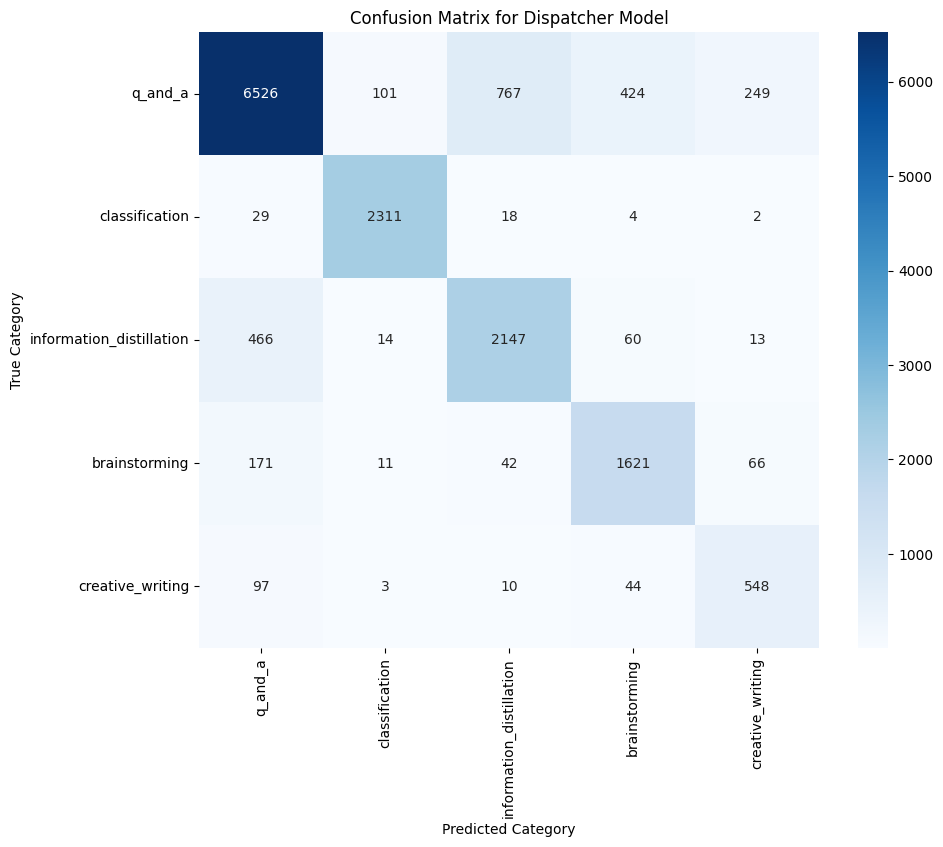

In [41]:
helper_utils.analyze_and_plot_results(partial_results, id2cat)

<a name='6-2'></a>
### 6.2 - Testing the Dispatcher on Unseen Instructions

Metrics and matrices are essential, but the ultimate measure of your AI dispatcher is how it performs in the wild. This is the final and most insightful test: confronting your model with completely new instructions it has never seen.

You will feed it a variety of prompts and observe its classifications in real-time. Does it correctly identify a question? Can it spot a request for a summary? This is where you see if you model has truly learned to generalize. 

Feel free to add your own custom instructions to the test list to push the dispatcher even further!

In [42]:
# EDITABLE CELL

test_examples = {
    "q_and_a": [
        {"instruction": "Explain the main stages of the water cycle.", "expected": "q_and_a"},
        {"instruction": "What is the historical significance of the Magna Carta?", "expected": "q_and_a"}
    ],
    "classification": [
        {"instruction": "Is this movie review positive or negative? 'The plot was amazing and the acting was superb!'", "expected": "classification"},
        {"instruction": "Is a tomato a fruit or a vegetable?", "expected": "classification"}
    ],
    "information_distillation": [
        {"instruction": "Summarize the main arguments of the article on climate change from this text.", "expected": "information_distillation"},
        {"instruction": "Pull out all the dates mentioned in the following project timeline.", "expected": "information_distillation"}
    ],
    "brainstorming": [
        {"instruction": "Come up with some catchy slogans for a new brand of eco-friendly sneakers.", "expected": "brainstorming"},
        {"instruction": "Suggest some team-building activities for a company retreat.", "expected": "brainstorming"}
    ],
    "creative_writing": [
        {"instruction": "Write a short story about a robot who discovers music.", "expected": "creative_writing"},
        {"instruction": "Compose a haiku about a rainy day.", "expected": "creative_writing"}
    ]
}

In [43]:
# Set the model to evaluation mode before starting the loop.
trained_finetuned_bert.eval()

print("--- Testing Dispatcher on New Instructions ---\n")

# Loop through each category and its list of examples in the dictionary.
for category, examples in test_examples.items():
    print(f"--- Category: {category} ---")
    for example in examples:
        instruction = example["instruction"]
        expected = example["expected"]
        
        # Get the model's prediction for the instruction.
        predicted = helper_utils.predict_category(
            model=trained_finetuned_bert,
            tokenizer=bert_tokenizer,
            text=instruction,
            device=device,
            id2cat=id2cat # Pass the mapping dictionary
        )
        
        # Check if the prediction was correct and set the result string/emoji.
        if predicted == expected:
            result = "✅ Correct"
        else:
            result = "❌ Incorrect"
            
        # Print the results in the desired format.
        print(f"Instruction: '{instruction}'")
        print(f"Expected:    {expected}")
        print(f"Predicted:   {predicted}")
        print(f"Result:      {result}\n")

--- Testing Dispatcher on New Instructions ---

--- Category: q_and_a ---
Instruction: 'Explain the main stages of the water cycle.'
Expected:    q_and_a
Predicted:   information_distillation
Result:      ❌ Incorrect

Instruction: 'What is the historical significance of the Magna Carta?'
Expected:    q_and_a
Predicted:   information_distillation
Result:      ❌ Incorrect

--- Category: classification ---
Instruction: 'Is this movie review positive or negative? 'The plot was amazing and the acting was superb!''
Expected:    classification
Predicted:   q_and_a
Result:      ❌ Incorrect

Instruction: 'Is a tomato a fruit or a vegetable?'
Expected:    classification
Predicted:   classification
Result:      ✅ Correct

--- Category: information_distillation ---
Instruction: 'Summarize the main arguments of the article on climate change from this text.'
Expected:    information_distillation
Predicted:   information_distillation
Result:      ✅ Correct

Instruction: 'Pull out all the dates mentio

## Conclusion: Your Dispatcher is Ready for Duty!

Congratulations! You've successfully built, fine-tuned, and tested a complete **AI Powered Request Dispatcher**. You started with a raw dataset and transformed it into a smart, efficient classification model capable of understanding and directing user intent, a vital component in any modern AI system.

Throughout this journey, you've put theory into practice. You saw how a pipeline of **tokenization**, where text is broken into smaller units, and **tensorization**, where tokens become numerical tensors for the model, forms the bedrock of any NLP task. You harnessed the power of a pre-trained model, **DistilBERT**, saving immense time and leveraging its deep, pre-existing knowledge of language.

Most importantly, you went beyond basic training. By implementing **weighted loss** to tackle class imbalance and applying a **partial-freezing** strategy, you engaged in the kind of parameter-efficient fine-tuning (PEFT) that makes developing high-performance models both practical and cost-effective. You didn't just build a model; you engineered a solution.

The dispatcher you've created is more than just an assignment. It represents a fundamental building block for countless advanced applications, from sophisticated chatbots and intelligent search engines to automated content creation tools. You now have the skills and the hands-on experience to build the smart systems of the future. Well done!

## Need a Hint on Hyperparameters?

While we strongly encourage you to experiment first, if you're stuck, run the following cell to see a set of hyperparameters that will help you achieve the target training metrics.

In [44]:
import base64

encoded_answer = "VHJ5IHRoZSBmb2xsb3dpbmcgaHlwZXJwYXJhbWV0ZXJzOgoKLSBsYXllcnNfdG9fdHJhaW4gPSA0Ci0gbGVhcm5pbmdfcmF0ZSA9IDVlLTUKLSBudW1fZXBvY2hzID0gNQ=="
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)

Try the following hyperparameters:

- layers_to_train = 4
- learning_rate = 5e-5
- num_epochs = 5
